# Desription

+ Show effects of multi-path on the communication signal

# Import

In [1]:
# importing
import numpy as np

from scipy import signal, stats

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline

In [2]:
# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=0)

matplotlib.rc('figure', figsize=(28, 8) )

# Initialization

### Get rrc impulse respone

In [3]:

########################
# find impulse response of an RRC filter
########################
def get_rrc_ir(K, n_sps, t_symbol, beta):
    
    ''' 
    Determines coefficients of an RRC filter 
    
    Formula out of: J. Huber, Trelliscodierung, Springer, 1992, S. 15
    
    NOTE: roll-off factor must not equal zero
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, sps factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''
    
    if beta == 0:
        beta = 1e-32
    
    K = int(K) 

    if ( K%2 == 0):
        raise ValueError('Length of the impulse response should be an odd number')
    
        
    # initialize np.array    
    rrc = np.zeros( K )
    
    # find sample time and initialize index vector
    t_sample = t_symbol / n_sps
    time_ind = range( -(K-1)//2, (K-1)//2+1)

    # assign values of rrc
    for t_i in time_ind:
        t = (t_i)* t_sample    

        if t_i == 0:
            rrc[ int( t_i+(K-1)//2 ) ] = (1-beta+4*beta/np.pi)

        elif np.abs(t) == t_symbol / ( 4 * beta ):             
            rrc[ int( t_i+(K-1)//2 ) ] = beta*np.sin( np.pi/(4*beta)*(1+beta) ) \
                - 2*beta/np.pi*np.cos(np.pi/(4*beta)*(1+beta)) 

        else:
            rrc[ int( t_i+(K-1)//2 ) ] = ( 4 * beta * t / t_symbol * np.cos( np.pi*(1+beta)*t/t_symbol ) \
                + np.sin( np.pi * (1-beta) * t / t_symbol ) ) / ( np.pi * t / t_symbol * (1-(4*beta*t/t_symbol)**2) )

    rrc = rrc  / np.sqrt(t_symbol)
               
    return rrc  

### Parameters

In [4]:
# constellation points are BPSK
constellation = [ -1, 1 ]

# number of symbols and samples per symbol
n_symb = 20

# parameters of the filter
beta = 0.33

n_sps = 8           # samples per symbol
syms_per_filt = 4  # symbols per filter (plus minus in both directions)

K_filt = 2 * syms_per_filt * n_sps + 1         # length of the fir filter

# set symbol time 
t_symbol = 1.0 

rrc = get_rrc_ir( K_filt, n_sps, t_symbol, beta )
rrc /= np.linalg.norm( rrc )

# constellation points equal to BPSK
constellation = [ -1, 1 ]

# Simulation

### Show effects on the signal when multi-path channel is applied

In [5]:

# generate random BPSK symbols
s = np.random.choice( constellation, n_symb )
  
# prepare sequence to be filtered by upsampling 
s_up = np.zeros(n_symb*n_sps, dtype=complex)        
s_up[::n_sps] = s

# apply RRC filtering        
s_Tx = np.convolve( s_up, rrc)    

#####
# apply channel 
#####

# "nice" channel
channel_delays_syms = [0, 2, 5]
channel_factors = [1.0, .5, .1]

# "bad guy" channel
#channel_factors = [1, .4, -0.3, .1, .1, .05, .05]
#channel_delays_syms = np.arange( 0, len(channel_factors) )

h_channel = np.zeros( ( np.max(channel_delays_syms ) + 1 ) * n_sps )

for k in np.arange(len(channel_delays_syms)):
    h_channel[ n_sps * channel_delays_syms[k] ] = channel_factors[k]

r = np.convolve( s_Tx, h_channel)

#####
# apply MF at the Rx 
#####    
y_mf_rrc = np.convolve(r, rrc)

y_down = y_mf_rrc[ K_filt-1 : K_filt-1 + n_symb * n_sps : n_sps ]


### 

Text(0.5, 0, '$n$')

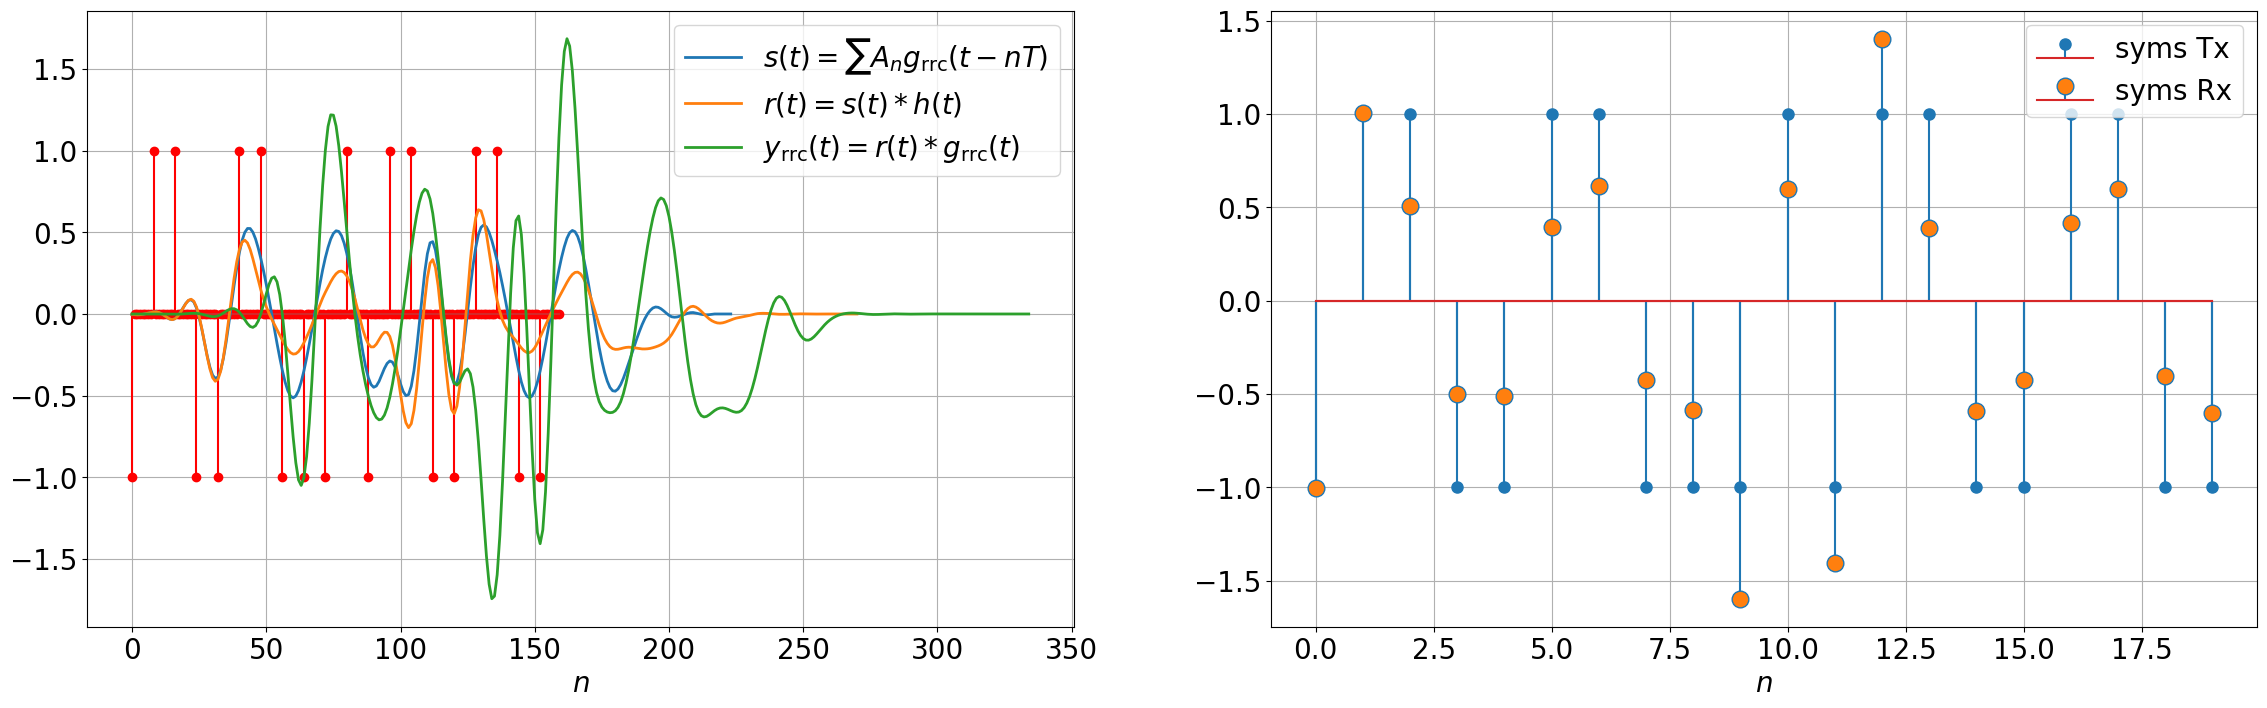

In [6]:
# show symbols and signals
plt.figure()    

plt.subplot(121)
plt.stem( np.arange(len(s_up)), np.real(s_up),'r')
plt.plot( np.arange(len(s_Tx)), np.real(s_Tx), linewidth=2.0, label='$s(t)=\sum A_ng_{\\mathrm{rrc}}(t-nT)$')    
plt.plot( np.arange(len(r)), np.real(r), linewidth=2.0, label='$r(t)=s(t)*h(t)$')        
plt.plot( np.arange(len(y_mf_rrc)), np.real(y_mf_rrc), linewidth=2.0, label='$y_{\\mathrm{rrc}}(t)=r(t)* g_{\\mathrm{rrc}}(t)$')            

plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('$n$')


# show symbols Tx and Rx; correct synch is assumed
plt.subplot(122)

markerline, stemlines, baseline = plt.stem( np.arange(len(s)), np.real(s), label='syms Tx')
plt.setp(markerline, 'markersize', 8, 'markerfacecolor', 'C0')

markerline, stemlines, baseline = plt.stem( np.arange(len(y_down)), np.real(y_down), '+', label='syms Rx')
plt.setp(markerline, 'markersize', 12,  'markerfacecolor', 'C1',)

plt.legend(loc='upper right')
plt.grid(True)
plt.xlabel('$n$')

### Show resulting BER

In [7]:

# snr range for simulation
snr_db_min = -10
snr_db_max = 30
snr_db_step = 2
EbN0_dB = np.arange( snr_db_min, snr_db_max + snr_db_step, snr_db_step)

EbN0 = 10**(EbN0_dB/10)

# maximum number of errors and symbols to be simulated
max_errors = 200
max_syms = 1e6

In [8]:
# initialize BER  and SER array with |mod| rows and |EbN0| columns
ber = np.zeros( len(EbN0) ) 

# loop for snrs
for ebn0 in EbN0:
    
    num_errors = 0
    num_syms = 0

    # loop for errors
    while (num_errors<max_errors and num_syms<max_syms):    
    
        # generate random binary vector and modulate the specified modulation scheme
        s = np.random.choice( constellation, n_symb )

          
        # prepare sequence to be filtered by upsampling 
        s_up = np.zeros(n_symb * n_sps, dtype=complex)        
        s_up[::n_sps] = s
    
        # apply RRC filtering        
        s_Tx = np.convolve( s_up, rrc)    
    
        # apply channel and add noise
        s_Rx = np.convolve( s_Tx, h_channel)
        
        sigma2 = 1 / ebn0
        n = np.sqrt( sigma2 / 2 ) * ( np.random.randn(len(s_Rx)) + 1j* np.random.randn(len(s_Rx)) )
    
        r = s_Rx + n
    
        # apply MF at the Rx 
        y_mf_rrc = np.convolve( r, rrc )
        
        y_down = y_mf_rrc[ K_filt-1 : K_filt-1 + n_symb * n_sps : n_sps ]
        
        s_est = np.sign( y_down )

        for k in np.arange(len(s_est)):
            if not np.isclose( s_est[k], s[k] ):
                num_errors += 1
    
        num_syms += n_symb

        ber[ np.where(EbN0 == ebn0) ] = num_errors/(num_syms*1.0)


    print( 'EbN0 simulated:', 10*np.log10(ebn0) )

EbN0 simulated: -10.0
EbN0 simulated: -8.0
EbN0 simulated: -6.0
EbN0 simulated: -4.000000000000001
EbN0 simulated: -2.0
EbN0 simulated: 0.0
EbN0 simulated: 2.0000000000000004
EbN0 simulated: 4.0
EbN0 simulated: 6.0
EbN0 simulated: 8.0
EbN0 simulated: 10.0
EbN0 simulated: 12.0
EbN0 simulated: 14.0
EbN0 simulated: 16.0
EbN0 simulated: 18.0
EbN0 simulated: 20.0
EbN0 simulated: 22.0
EbN0 simulated: 24.0
EbN0 simulated: 26.0
EbN0 simulated: 28.0
EbN0 simulated: 30.0


(1e-06, 1)

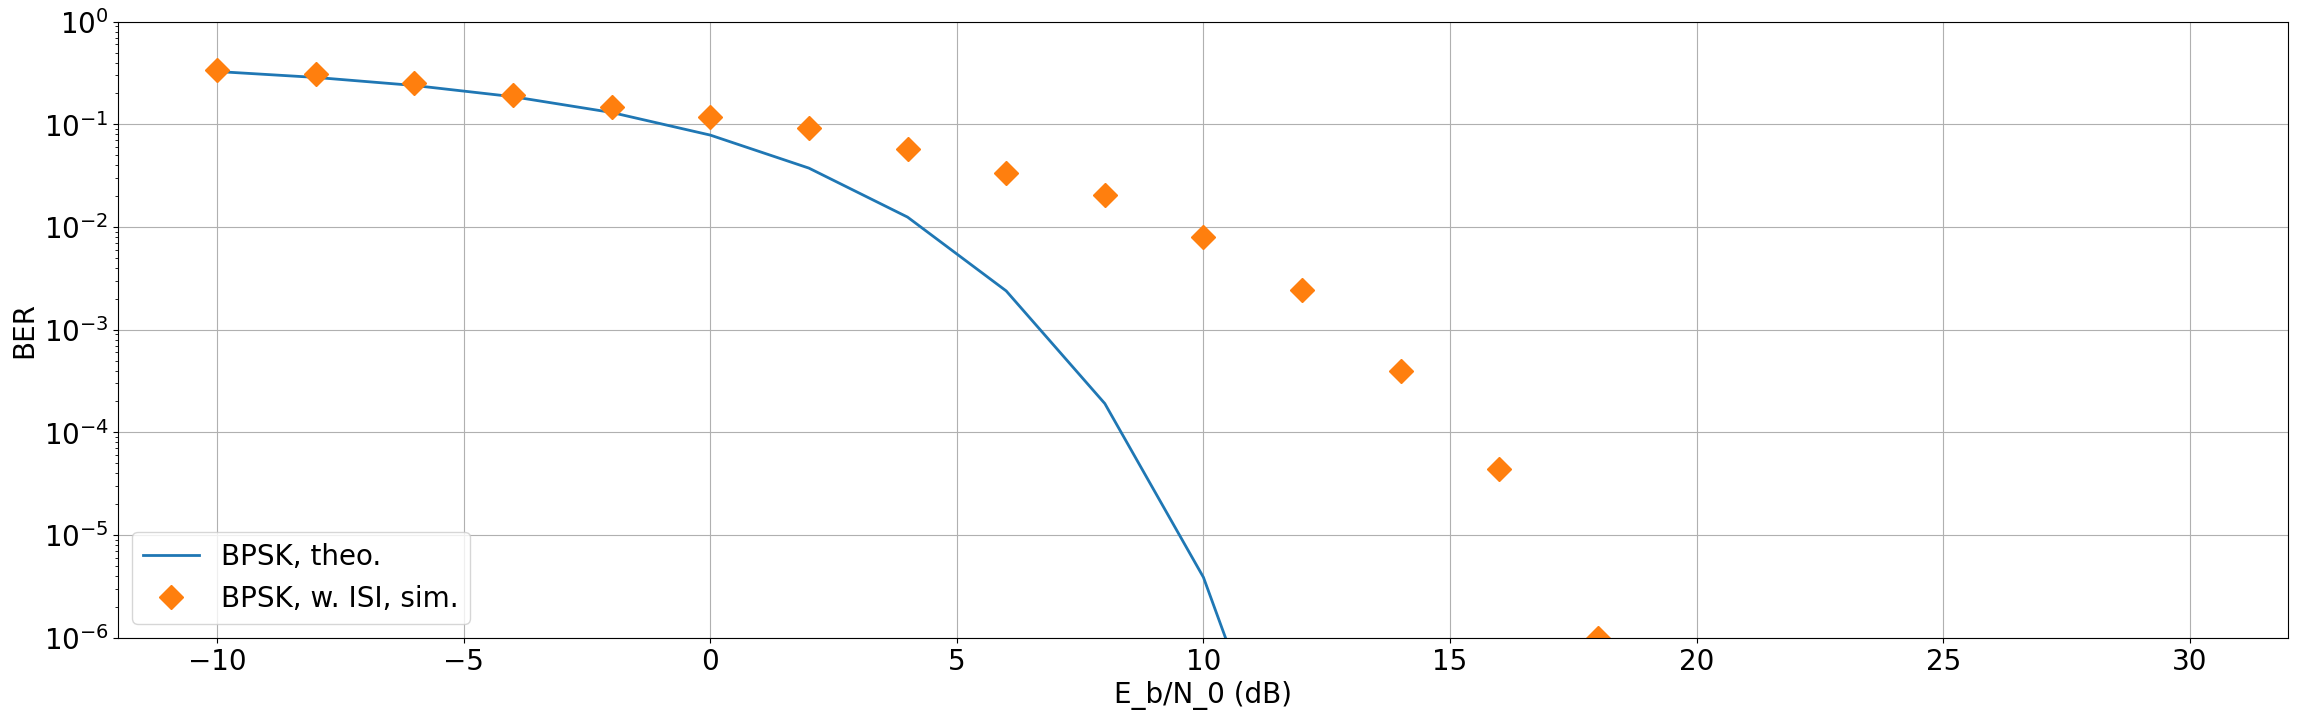

In [10]:
ber_theo = 1 - stats.norm.cdf( np.sqrt( 2 * EbN0 ) )


plt.figure()
plt.plot( EbN0_dB, ber_theo, linewidth=2.0, label = "BPSK, theo.")    
plt.plot( EbN0_dB, ber, 'D', linewidth=2.0, markersize = 12, label = "BPSK, w. ISI, sim." )    

plt.yscale('log')
plt.grid(True)
plt.legend(loc='lower left')

plt.xlabel('E_b/N_0 (dB)')
plt.ylabel('BER')
plt.ylim( (1e-6, 1))
